## Cart Pole Demo 2 using OpenAI gym  
## Policy Gradient

### University of Virginia
### Reinforcement Learning
#### Last updated: October 12, 2023

---


**Source:** Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. Aurélien Géron.

---

### First a Refresh

Let's briefly review the content from Demo 1: Basics and Simple Policy

We will work with [Gym](https://gym.openai.com/) from Open AI.

We revisit the [**CartPole**](https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/CartPole-v1/original.mp4) problem.

The *simple policy* didn't perform very well: the average reward was about 42.

We want to see if we can do better using a Policy Gradient algorithm.

### Setup and First Steps

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

Load the environment

In [2]:
env = gym.make("CartPole-v1")
state = env.reset()

Given the state, we take an action. The next state comes from the environment, which is encoded in `gym`.

Components:   
[0]: cart horizontal position (0.0 = center)  
[1]: velocity (positive means right)  
[2]: angle of the pole (0.0 = vertical)  
[3]: pole's angular velocity (positive means clockwise)

In [ ]:
state

array([-0.02744055,  0.04389752, -0.01207079, -0.019533  ])

In [ ]:
# state space number of components
env.observation_space.shape[0]

4

The action space consists of two options: 

[0]: move cart left   
[1]: move cart right

In [3]:
env.action_space

Discrete(2)

Let's take an action, draw a sample and look at the results.

In [4]:
# move right
action = 1

# take a step and get next state, reward from environment
staticmethod, reward, done, info = env.step(action)

print('state', state)
print('reward', reward)
print('done', done)
print('info', info)

state [ 0.02822481 -0.01191032 -0.01980916  0.04693194]
reward 1.0
done False
info {}


**Reward and Episode**  

For each time step that the cart keeps the pole balanced, it earns reward 1.

If the pole tilts too much or if the cart moves off screen, `reward=0` and `done=True` (the episode will end).

When the episode ends, a new episode may begin. The process learns cumulatively from each episode.

**Simple policy**:  

When the pole leans left (negative angle), move left. When the pole leans right (positive angle), move right.

Run many episodes and visualize their reward distribution.

In [5]:
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

num_episodes = 1000
num_steps = 100
rewards = []

for episode in range(num_episodes):
    ep_reward = 0
    obs = env.reset()
    for step in range(num_steps):
        action = simple_policy(obs)
        obs, reward, done, info = env.step(action)
        ep_reward += reward
        if done:
            break

    rewards.append(ep_reward)

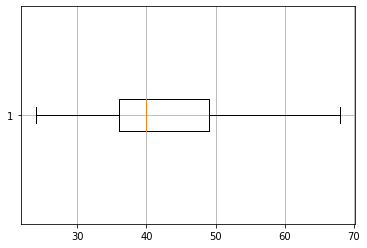

In [6]:
plt.boxplot(rewards, vert=False)
plt.grid()
plt.show()

### Neural Network Policy

Now we try a more sophisticated policy: let's use a neural network.

The network will take **state as input**. The output node will contain the probability of the actions.

Since there are two actions (left, right), we require one output node.  
Node will output probability of right (so prob of left is implied).

For simplicity, we will use one hidden layer. 

Number of nodes in hidden layer is a hyperparameter.

**Instantiate the Model**

In [7]:
import tensorflow as tf
from tensorflow import keras

num_inputs = env.observation_space.shape[0]
num_hidden_neurons = 10

model = keras.models.Sequential([
    keras.layers.Dense(num_hidden_neurons, activation="relu", input_shape=[num_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

**Training the Model**

We'll need some functions to preprocess the rewards and to evolve the system.

Game Plan: 

- write a function to evolve the system one step
- write a function that runs multiple episodes, calling the *single step* function
- write a function to discount rewards, to adjust for time value of money
- normalize the discounted rewards, as neural networks perform better on normalized data
- set up the parameters and hyperparameters
- code a training loop

Here is **code to play out a single step and compute the gradient of the loss**

In [8]:
def play_single_step(env, state, model, loss_fn):
    with tf.GradientTape() as tape:
        left_prob = model(state[np.newaxis])

        # want action=left w probability=left_prob, so sample from uniform
        action = (tf.random.uniform([1, 1]) > left_prob) # go right if uniform > left_prob

        #  y_target=1 if action=left, target=0 if action=right
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)

        # compute the loss function
        loss = tf.reduce_mean(loss_fn(y_target, left_prob))

    # compute the gradient of the loss wrt model parameters
    grads = tape.gradient(loss, model.trainable_variables)

    # take the selected action and get the results
    state, reward, done, info = env.step(int(action[0, 0].numpy()))
    return state, reward, done, grads

Next, define a function to play out several episodes.

This will use `play_single_step()` 

In [9]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        # for each episode, reset rewards, grads, state
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
          # take a step
            obs, reward, done, grads = play_single_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        # append rewards, grads for episode
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

**Discounting** 

Rewards need to be adjusted for time value of money, so we apply a discount factor.

We define a discounting function to:

- take a list of rewards as input
- return an array containing the sum of future discounted rewards at each time step

In [10]:
def discount_rewards(rewards, disc_factor):
    disc_rewards = np.array(rewards, float)
    for step in range(len(rewards) - 2, -1, -1):
        disc_rewards[step] += disc_rewards[step + 1] * disc_factor
    return disc_rewards

In [11]:
# test the function

rewards = [100, 10, -50, -100]
disc_factor = 0.95

discount_rewards(rewards, disc_factor)

array([ -21.3625, -127.75  , -145.    , -100.    ])

**Normalizing the sum of discounted rewards**

We define a function to normalize the sum of future discounted rewards across episodes by:

- subtracting the mean (center)
- dividing by standard deviation (scale)

In [12]:
def discount_and_normalize_rewards(episode_rewards, disc_factor):

    # for each episode, compute sum of future discounted reward
    all_disc_rewards = [discount_rewards(rewards, disc_factor) for rewards in episode_rewards]
    
    # concatenate all rewards across episode to compute statistics
    flat_disc_rewards = np.concatenate(all_disc_rewards)
    reward_mean = flat_disc_rewards.mean()
    reward_std = flat_disc_rewards.std()

    # normalize each value
    return [(disc_rewards - reward_mean) / reward_std for disc_rewards in all_disc_rewards]

In [13]:
# test the function

rewards1 = [100, 10, -50, -100]
rewards2 = [50, 25]
disc_factor = 0.95

discount_and_normalize_rewards([rewards1, rewards2], disc_factor)

[array([ 0.34418365, -0.96991597, -1.18298817, -0.62714765]),
 array([1.51901435, 0.91685379])]

Setup

In [28]:
# params and hyperparams

num_iterations = 50
num_episodes_per_update = 10
num_max_steps = 100
discount_factor = 0.95

# optimizer and loss function

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

### Training loop

We will use a variant of the REINFORCE algorithm introduced earlier.

Recall that REINFORCE policy parameter updates are made by using the product of two terms:

- the return on a path $G_t$ 
- the gradient of the policy taking an action divided by the probability of taking the action

Update formula:

$\boldsymbol{\theta_{t+1}} = \boldsymbol{\theta_t} + \alpha G_t \frac{\nabla \pi(A_t|S_t, \boldsymbol{\theta_t})}{\pi(A_t|S_t, \boldsymbol{\theta_t})} $

The below code will loop over each policy parameter to: 

- compute the product of the return and the gradient for each of the episodes and time steps  
- average the products and use this average to update the parameters

The goal is to improve the policy with these gradients.

In [29]:
for iteration in range(num_iterations):

    rewards_all, grads_all = play_multiple_episodes(
                                                    env, 
                                                    num_episodes_per_update, 
                                                    num_max_steps, 
                                                    model, 
                                                    loss_fn)
    
    final_rewards_all = discount_and_normalize_rewards(rewards_all,
                                                       discount_factor)
    grads_mean = []

    # loop over policy params (trainable_variables)
    for var_ix in range(len(model.trainable_variables)):

        # average the return-weighted gradients
        mean_grads = tf.reduce_mean(
            [return_final * grads_all[episode_index][step][var_ix]
             for episode_index, final_rewards in enumerate(final_rewards_all)
                 for step, return_final in enumerate(final_rewards)], axis=0)
        
        grads_mean.append(mean_grads)

    optimizer.apply_gradients(zip(grads_mean, model.trainable_variables))

**Policy Evaluation**

Now that the model is trained, we can use it as the policy and evaluate performance.

Run several episodes, apply the model as the policy and compute rewards.

In [30]:
num_episodes = 1000
num_steps = 100
rewards = []

for episode in range(num_episodes):
    if episode % 50 == 0:
      print('episode', episode, 'of', num_episodes)
    ep_reward = 0
    state = env.reset()
    for step in range(num_steps): # steps in each episode
        left_prob = model(state[np.newaxis]) # apply model as policy

        # want action=left w probability=left_prob, so sample from uniform
        action = tf.random.uniform([1, 1]) > left_prob

        # given action, take a step and collect the results
        state, reward, done, info = env.step(int(action[0, 0].numpy()))

        ep_reward += reward
        if done:
            break

    rewards.append(ep_reward)

episode 0 of 1000
episode 50 of 1000
episode 100 of 1000
episode 150 of 1000
episode 200 of 1000
episode 250 of 1000
episode 300 of 1000
episode 350 of 1000
episode 400 of 1000
episode 450 of 1000
episode 500 of 1000
episode 550 of 1000
episode 600 of 1000
episode 650 of 1000
episode 700 of 1000
episode 750 of 1000
episode 800 of 1000
episode 850 of 1000
episode 900 of 1000
episode 950 of 1000


Print reward statistics: minimum, mean, max

In [31]:
np.min(rewards), np.mean(rewards), np.max(rewards)

(16.0, 98.501, 100.0)

Recall that earlier, the simple policy produced a mean reward of 42, so this is much better on average!

---

**Question 1**. See if there are any simple modifications you can make to improve the mean reward.

**Question 2**. Is REINFORCE a Monte Carlo method? Explain your answer.

**Question 3**. Is REINFORCE an on-policy method or an off-policy method? Explain your answer.

**Question 4**. What is the largest challenge with policy gradient methods?

**Question 5a**. Select a baseline function of your choosing and modify REINFORCE to use this baseline. Explain why you selected this baseline. 

**Question 5b**. To understand whether REINFORCE with baseline performs better than REINFORCE, plot total rewards versus episode number for each method. Explain your result.